## Figure 1
Particle surface tension for given wet radius under different assumptions of surface-partitioning by organics

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install "open_atmos_jupyter_utils"
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
import warnings
from numba.core.errors import NumbaExperimentalFeatureWarning
import numpy as np

from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot

from PySDM import Formulae
from PySDM.physics import si

from PySDM_examples.Singer_Ward.aerosol import AerosolBetaCaryophylleneDark
from PySDM_examples.Singer_Ward.constants_def import SINGER_CONSTS, plot_colors, plot_lines, plot_names

In [3]:
# aerosol creation
FORMULAE = Formulae(constants=SINGER_CONSTS)
WATER_MOLAR_VOLUME = FORMULAE.constants.water_molar_volume
aerosol = AerosolBetaCaryophylleneDark(water_molar_volume=WATER_MOLAR_VOLUME, Forg=0.5, N_a=200)

# formulae creation
formulae_bulk = Formulae(surface_tension='Constant', constants=SINGER_CONSTS)
formulae_ovad = Formulae(
    surface_tension='CompressedFilmOvadnevaite',
    constants={
        **SINGER_CONSTS,
        'sgm_org': 25e-3 * si.J / si.m**2,
        'delta_min': 4e-10 * si.m,
    }
)
formulae_sl = Formulae(
    surface_tension='SzyszkowskiLangmuir',
    constants={
        **SINGER_CONSTS,
        'RUEHL_nu_org': aerosol.modes[0]['nu_org'],
        'RUEHL_A0': 75e-20 * si.m**2,
        'RUEHL_C0': np.exp(-15),
        'RUEHL_sgm_min': 25e-3 * si.J / si.m**2,
    }
)
formulae_ruehl = Formulae(
    surface_tension='CompressedFilmRuehl',
    constants={
        **SINGER_CONSTS,
        'RUEHL_nu_org': aerosol.modes[0]['nu_org'],
        'RUEHL_A0': 75e-20 * si.m**2,
        'RUEHL_C0': np.exp(-15),
        'RUEHL_sgm_min': 25e-3 * si.J / si.m**2,
        'RUEHL_m_sigma': 15e16 * si.J / si.m**4,
    }
)

# aerosol and thermodynamic conditions
T = 300 * si.K
r_dry = 50 * si.nm
v_dry = formulae_ovad.trivia.volume(r_dry)

# plotting info
r_wet = np.logspace(np.log(50 * si.nm), np.log(2000 * si.nm), base=np.e, num=100)
v_wet = formulae_ovad.trivia.volume(r_wet)
r_wet_ticks_nm = (100, 200, 300, 500, 1000, 2000)

Constant
CompressedFilmOvadnevaite
SzyszkowskiLangmuir
CompressedFilmRuehl


Text(0.5, 0, 'Wet radius [nm]')

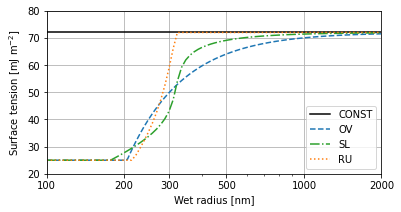

In [4]:
fig,ax = pyplot.subplots(1, 1, figsize=(6,3), sharex=True, sharey=False)

for formulae in (formulae_bulk, formulae_ovad, formulae_sl, formulae_ruehl):
    model = formulae.surface_tension.__name__
    sigma = np.ones(len(v_wet))
    print(model)
    if model in ("CompressedFilmRuehl", "SzyszkowskiLangmuir"):
        for j,vw in enumerate(v_wet):
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', category=NumbaExperimentalFeatureWarning)
                sigma[j] = formulae.surface_tension.sigma(T, vw, v_dry, aerosol.modes[0]['f_org'])
    else:
        sigma = formulae.surface_tension.sigma(T, v_wet, v_dry, aerosol.modes[0]['f_org'])
    
    RH_eq = formulae.hygroscopicity.RH_eq(r_wet, T, aerosol.modes[0]['kappa'][model], r_dry**3, sigma)

    if not type(sigma) is type(v_wet):
        sigma = np.ones(len(v_wet)) * sigma
    # plot surface tension
    ax.plot(
        r_wet / si.nm,
        sigma / (si.mJ / si.m**2),
        label=plot_names[model], 
        color=plot_colors[model],
        linestyle=plot_lines[model]
    )

# plot attributes
ax.grid()
ax.set_xscale('log')
ax.set_xticks(r_wet_ticks_nm, r_wet_ticks_nm)
ax.set_xlim(r_wet[0] / si.nm, r_wet[-1] / si.nm)
ax.set_ylabel('Surface tension [mJ m$^{-2}$]')
yticks = (20, 30, 40, 50, 60, 70, 80)
ax.set_yticks(yticks, yticks)
ax.set_ylim(20, 80)
ax.set_xlim(100, 2000)
ax.legend(loc=4)
ax.set_xlabel('Wet radius [nm]')

# show_plot("fig1.pdf")